### To do


In [75]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, r2_score
from sklearn.metrics import auc, confusion_matrix
from sklearn.pipeline import make_pipeline

### Loading the data

In [76]:
raw = pd.read_excel('data/dataframe_elections.xlsx')
print('Taille initiale du DF :', raw.shape)

# Données d'identification
id_list = ['an', 'dep', 'circo', 'code', 'nom', 'prenom', 'nuance', 'nuance_groupe', 'taux_vote_leg', 'second_tour']
df_id = raw[id_list]

# drop colonnes
drop_list = ['dep', 'circo', 'code', 'inscrits', 'circo_parti', 'circo_nuance',
             'nom', 'prenom', 'etiquette', 'nuance', 'voix', 'second_tour']
raw = raw.drop(drop_list, axis=1)

print('Taille du DF après retrait des colonnes inutiles :', raw.shape)

Taille initiale du DF : (36919, 83)
Taille du DF après retrait des colonnes inutiles : (36919, 71)


In [77]:
def generate_df(raw_data, keep_list, penalty=.8):
    # à garder obligatoirement pour identifier les lignes et créer les labels
    keep_nuance = 'nuance_groupe' in keep_list
    keep_list.extend(['an', 'c_dep', 'nuance_groupe', 'p_inscrits', 'p_exprimes'])

    df = raw_data.drop([col for col in raw_data.columns if col not in keep_list], axis=1)
    #print(df.columns)

    # Gestion des NaN au niveau du score du candidat aux législatives précédentes
    years = [2002, 2007, 2012, 2017]
    partis = ['EXG', 'COM', 'FI', 'DVG', 'ECO', 'SOC', 'RDG', 'MDM',
              'UDI', 'DVD', 'LR', 'DLF', 'FN', 'EXD', 'REG', 'DIV']
    
    # TODO : POUR LES CANDIDATS "EN MARCHE", PAR QUOI REMPLIR LE SCORE DES CANDIDATS A LA PREC LEG ?
    
    if 'score_candidat_prec_leg_ins' in keep_list:
        for parti in partis:
            #print('\nRemplissage des valeurs manquantes pour {} :'.format(parti))
            for year in years:
                mask = (df['an']==year) & (df['nuance_groupe']==parti)
                mask_2 = (df['an']==year - 5) & (df['nuance_groupe']==parti)
                mean = np.mean(df['p_inscrits'][mask_2]) * penalty # moyenne des voix du parti 5 ans avant (% d'inscrits)
                df.loc[mask, 'score_candidat_prec_leg_ins'] = df['score_candidat_prec_leg_ins'][mask].fillna(value=mean)
                #print('La moyenne du parti en {} est {:.2f}%'.format(year - 5, mean * 100))

        mean = np.mean(df.p_inscrits) * penalty
        df.score_candidat_prec_leg_ins = df.score_candidat_prec_leg_ins.fillna(value=mean)
        
    if 'score_candidat_prec_leg_expr' in keep_list:
        for parti in partis:
            #print('\nRemplissage des valeurs manquantes pour {} :'.format(parti))
            for year in years:
                mask = (df['an']==year) & (df['nuance_groupe']==parti)
                mask_2 = (df['an']==year - 5) & (df['nuance_groupe']==parti)
                mean = np.mean(df['p_exprimes'][mask_2]) * penalty # moyenne des voix du parti 5 ans avant (% exprimés)
                df.loc[mask, 'score_candidat_prec_leg_expr'] = df['score_candidat_prec_leg_expr'][mask].fillna(value=mean)
                #print('La moyenne du parti en {} est {:.2f}%'.format(year - 5, mean * 100))

        mean = np.mean(df.p_exprimes)
        df.score_candidat_prec_leg_expr = df.score_candidat_prec_leg_expr.fillna(value=mean)

    # Gestion des NaN : Autres variables. Remplacement des valeurs manquantes par la moyenne nationale
    features_a_completer = ['chom_tot', 'chom_jeunes', 'chom_adultes', 'chom_seniors',
                           'p_agri', 'p_commercants', 'p_cadres', 'p_intermed', 'p_employes',
                           'p_ouvriers', 'd_brevet', 'd_bep', 'd_bac', 'd_sup']
    for feature in features_a_completer:
        if feature in keep_list:
            #print('\nRemplissage des valeurs manquantes pour {} :'.format(feature))
            for year in years:
                mask = (df['an']==year)
                mean = np.mean(df[feature][mask])
                #print('La moyenne de la feature pour {} est {:.2f}%'.format(year, mean * 100))
                df.loc[mask, feature] = df[feature][mask].fillna(value=mean)

    # Catégorisation
    if 'score_candidat_prec_leg_cat' in keep_list:
        if 'score_candidat_prec_leg_expr' in keep_list:
            df['score_candidat_prec_leg_cat'] = pd.cut(df['score_candidat_prec_leg_expr'],
                                                       bins=[-1, -.01, .05, .1, .15, .25, 1],
                                                       labels=['N/A', 'A', 'B', 'C', 'D', 'E'])
        elif 'score_candidat_prec_leg_ins' in keep_list:
            df['score_candidat_prec_leg_cat'] = pd.cut(df['score_candidat_prec_leg_ins'],
                                                       bins=[-1, -.01, .05, .1, .15, .25, 1],
                                                       labels=['N/A', 'A', 'B', 'C', 'D', 'E'])

    df = df[df.an > 1997]
    df = df[df.nuance_groupe!='DIV'] # On retire les candidats "Divers" (pour l'entraînement ET la prédiction)
    df = df[df.c_dep!=99] # Retrait des Français de l'Etranger
    
    df = df.drop('c_dep', axis=1)
    
    if not keep_nuance:
        df = df.drop('nuance_groupe', axis=1)
    
    print('Format du dataframe :', df.shape)
    print(df.isnull().sum())
    
    return df

In [88]:
def train_val_splits(df, year_for_validation, target, scaler=MinMaxScaler()):
    # Liste des variables dummies et binaires pour les exclure de la normalisation
    dummies_list = ['bloc', 'sexe', 'an', 'p_inscrits', 'p_exprimes', 'dep', 'circo',
                    'geo_frontalier', 'geo_dom', 'geo_idf',
                    'circo_nuance_groupe', 'circo_bloc', 'nuance_groupe',
                    'circo_nuance_groupe_pres', 'circo_pres_meme_nuance', 'circo_meme_nuance_president',
                    'circo_leg_meme_nuance',
                    'depute_sortant', 'ancien_depute', 'au_gouvernement', 'ancien_ministre', 'membre_majorite',
                    #'nb_candidats_meme_bloc', 'nb_candidats_circo',
                    'score_candidat_prec_leg_cat',
                    'score_candidat_prec_leg_expr', 'score_candidat_prec_leg_ins',
                    #'nb_acces_second_tour'
                   ]
    scale_list = [col for col in df.columns if col not in dummies_list]

    df = pd.get_dummies(df, drop_first=True)
    
    drop_list = ['an', 'p_inscrits', 'p_exprimes']
    df_train = df[(df.an != 2017) & (df.an != year_for_validation)].dropna(how='any')
    y_train = df_train[target]
    X_train = df_train.drop(drop_list, axis=1)
    
    df_val = df[df.an == year_for_validation].dropna(how='any')
    y_val = df_val[target]
    X_val = df_val.drop(drop_list, axis=1)
    
    # Normalisation du dataframe
    if scaler:
        print('Variables à normaliser', scale_list)
        X_train[scale_list] = scaler.fit_transform(X_train[scale_list])
        X_val[scale_list] = scaler.transform(X_val[scale_list])

    print('Format des ensembles de train et de validation :')
    print(X_train.shape, X_val.shape)
    
    return X_train, X_val, y_train, y_val

In [89]:
def get_classif(y_pred, y_val, id_val, target, strategy):
    from scipy.stats import rankdata
    
    res = pd.concat([id_val, pd.DataFrame(y_val)], axis=1, join='inner')
    res['prediction'] = y_pred
    res['classement'] = 0
    res['qualif'] = 'N'
    
    for circo in set(res.code):
        # classement des candidats par circonscription
        res.loc[res.code==circo, 'classement'] = rankdata(-res.prediction[res.code==circo], method='ordinal')
        
        # normalisation des votes pour que la somme soit égale à 100%
        res.loc[res.code==circo, 'prediction'] /= np.sum(res.loc[res.code==circo, 'prediction'])
        
        if target=='p_exprimes':
            taux_E = 1
            taux_O = np.float(res.loc[(res.code==circo) & (res.classement==1), 'taux_vote_leg'])
        elif target=='p_inscrits':
            taux_E = 1 / np.float(res.loc[(res.code==circo) & (res.classement==1), 'taux_vote_leg'])
            taux_O = 1
            
        # simulation des qualifiés pour le second tour
        i = 1
        q = 0
        while True:
            #print(res.loc[(res.code==circo) & (res.classement==i), 'prediction'].values)
            if (res.loc[(res.code==circo) & (res.classement==i), 'prediction'].values) * taux_E >= .5:
                res.loc[(res.code==circo) & (res.classement==i), 'qualif'] = 'E'
                if strategy == 'O':
                    q += 1
                elif strategy == 'E':
                    break
            elif (res.loc[(res.code==circo) & (res.classement==i), 'prediction'].values) * taux_O >= .125:
                res.loc[(res.code==circo) & (res.classement==i), 'qualif'] = 'O'
                q += 1
            elif q < 2:
                res.loc[(res.code==circo) & (res.classement==i), 'qualif'] = 'O'
                q += 1
            else:
                break

            i += 1
        
    res['ecart'] = res['prediction'] - res[target]
    
    return res

In [112]:
def analyze_predictions(df_predictions, target):
    n = df_predictions.shape[0]
    print('Prédictions pour {} candidats.'.format(n))

    ecarts_absolus = abs(df_predictions.ecart)
    max_ecart = np.max(ecarts_absolus)
    grid = np.arange(max_ecart, step=.01)
    ecarts_grid = []

    for point in grid:
        ecarts_grid.append(np.sum(ecarts_absolus < point))

    print('La MAE est : {:.2f}%'.format(
            mean_absolute_error(df_predictions[target], df_predictions.prediction) * 100))
    print('La plus grosse erreur est : {:.2f}%'.format(max_ecart * 100))
    print('Le score r2 est : {:.2f}'.format(r2_score(df_predictions[target], df_predictions.prediction)))

    point_list = [.01, .02, .05, .1]
    ecart_list = [np.sum(ecarts_absolus < point) for point in point_list]

    plt.figure(1, figsize=(13, 3))
    plt.subplot(121)
    plt.plot(grid, ecarts_grid)
    for i in range(len(point_list)):
        plt.plot(point_list[i], ecart_list[i], 'ro')
        plt.text(point_list[i]+.005, ecart_list[i]-400, '{:.2f}%'.format(ecart_list[i]/n))

    plt.title('Nb d\'obs en dessous d\'un seuil d\'erreur')
    plt.xlabel('Seuils d\'erreur')

    plt.subplot(122)
    plt.hist(df_predictions['ecart'], bins=50)
    plt.title('Répartition globale des erreurs')

    # comparaison de la distribution des erreurs, parti par parti
    from scipy.stats import gaussian_kde
    plt.figure(2, figsize=(15,4))
    x_grid = np.arange(min(df_predictions['ecart']), max(df_predictions['ecart']), step=.01)
    
    nuances = {'FI': 'red','ECO': 'green', 'SOC': 'pink', 'RDG': 'grey', 'MDM': 'orange', 'UDI': 'yellow',
               'LR': 'blue', 'DLF': 'darkblue', 'FN': 'black', 'REG': 'teal'}
    for nuance in nuances:
        n_pred = df_predictions[(df_predictions['nuance_groupe']==nuance)
                                & ((df_predictions['qualif']=='E')
                               | (df_predictions['qualif']=='O'))].shape[0]
        n_reel = df_predictions[(df_predictions['nuance_groupe']==nuance)
                                & ((df_predictions['second_tour']=='E')
                               | (df_predictions['second_tour']=='O'))].shape[0]
        print('{}: {} prédits | Réel {}'.format(nuance, n_pred, n_reel))
        try: # cas où le parti n'est pas représenté à l'élection prédite
            pdf = gaussian_kde(df_predictions['ecart'][df_predictions['nuance_groupe']==nuance],
                               bw_method=.9).evaluate(x_grid)
            plt.plot(x_grid, pdf, color=nuances[nuance], label=nuance, lw=2)
        except:
            pass

    plt.title('Répartition des erreurs selon le parti')
    plt.legend(loc='best')

    n_correct = np.sum(df_predictions.second_tour == df_predictions.qualif)
    print('\n{} prédictions correctes sur {} (soit {:.1f}%)'.format(n_correct, n, 100 * n_correct / n))

    print('\nMatrice de confusion. En colonne les classes prédites, en ligne les classes réelles.')
    cm = confusion_matrix(df_predictions.second_tour, df_predictions.qualif, labels=['E', 'O', 'N'])
    print(cm)

    f1_E = f1_score(df_predictions.second_tour, df_predictions.qualif, labels='E', average='micro')
    print('Score F1 pour la classe E : {:.1f}%'.format(f1_E * 100))
    f1_O = f1_score(df_predictions.second_tour, df_predictions.qualif, labels='O', average='micro')
    print('Score F1 pour la classe O : {:.1f}%'.format(f1_O * 100))
    f1_N = f1_score(df_predictions.second_tour, df_predictions.qualif, labels='N', average='micro')
    print('Score F1 pour la classe N : {:.1f}%'.format(f1_N * 100))
    plt.show()
    
    return

### Choix des paramètres

In [107]:
# Sélection des features
keep_list = ['geo_frontalier', 'geo_dom', 'geo_idf',
    'part_impose',
    'chom_tot',
    'revenus_q1', 'revenus_med', 'revenus_q3', 'ecart_revenus',
    'chom_jeunes', 'chom_adultes', 'chom_seniors',
    'p_agri', 'p_commercants', 'p_cadres', 'p_intermed', 'p_employes',
    'p_ouvriers', 'd_brevet', 'd_bep', 'd_bac', 'd_sup'
    'circo_leg_meme_nuance', 'circo_pres_meme_nuance', 'circo_meme_nuance_president',
    'nb_candidats_meme_bloc',
    'nb_candidats_circo',
    'score_nuance_groupe_pres', 'score_bloc_pres',
    #'score_candidat_prec_leg_ins',
    'score_candidat_prec_leg_expr',
    #'score_candidat_prec_leg_cat',
    #'score_nuance_groupe_prec_leg', #(un peu mauvais)
    #'score_bloc_prec_leg', #(mauvais pour le score)
    #'nuance_groupe',
    #'taux_vote_pres', 'taux_vote_leg',
    'depute_sortant', 'ancien_depute', 'au_gouvernement', 'ancien_ministre', 'membre_majorite',
    'nb_acces_second_tour',
    'sexe'
]

scaler = MinMaxScaler()
#scaler = StandardScaler()

# Prédire les score en % des voix exprimées ou % des inscrits sur les listes électorales
target_values = 'p_exprimes' # 'p_inscrits'
target_year = 2012

# Taux par lequel on multiplie les score à la législative précédente qui étaient à la base des N/A
penalty = .9

# si 'O' : on note les potentiels qualifiés dès le 1er tour mais on indique aussi le candidat arrivé 2ème
# si 'E' : si un candidat est classé 'E', ses concurrents sont automatiquement tous classés 'N'
strategy = 'O' 

In [108]:
df = generate_df(raw, keep_list, penalty=penalty)
X_train, X_val, y_train, y_val = train_val_splits(df, target_year, target_values, scaler)

Format du dataframe : (26150, 38)
an                                 0
geo_frontalier                     0
geo_dom                            0
geo_idf                            0
part_impose                        0
revenus_q1                         0
revenus_med                        0
revenus_q3                         0
ecart_revenus                      0
chom_tot                           0
chom_jeunes                        0
chom_adultes                       0
chom_seniors                       0
p_agri                             0
p_commercants                      0
p_cadres                           0
p_intermed                         0
p_employes                         0
p_ouvriers                         0
d_brevet                           0
d_bep                              0
d_bac                              0
circo_pres_meme_nuance             0
circo_meme_nuance_president        0
score_nuance_groupe_pres           0
score_bloc_pres                    0
scor

In [109]:
X_train.head(2)

,geo_frontalier,geo_dom,geo_idf,part_impose,revenus_q1,revenus_med,revenus_q3,ecart_revenus,chom_tot,chom_jeunes,...,score_candidat_prec_leg_expr,depute_sortant,ancien_depute,au_gouvernement,ancien_ministre,membre_majorite,nb_acces_second_tour,nb_candidats_meme_bloc,nb_candidats_circo,sexe_M
14488,1,0,0,0.546669,0.512791,0.363924,0.236599,0.177559,0.061475,0.111776,...,0.053292,0.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.347826,1
14489,1,0,0,0.546669,0.512791,0.363924,0.236599,0.177559,0.061475,0.111776,...,0.318378,0.0,0.0,0.0,0.0,1.0,0.0,0.111111,0.347826,1


### Choix de modèle

In [110]:
from sklearn.ensemble import RandomForestRegressor
#rf = make_pipeline(PCA(), RandomForestRegressor(n_jobs=-1, n_estimators=100))
rf = RandomForestRegressor(n_jobs=-1, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
sorted(list(zip(rf.feature_importances_*100, X_train.columns)), reverse=True)

[(65.588199804598048, 'score_candidat_prec_leg_expr'),
 (11.96408513416932, 'membre_majorite'),
 (6.144028219717371, 'score_nuance_groupe_pres'),
 (4.0712885837223958, 'score_bloc_pres'),
 (1.9551428263164403, 'depute_sortant'),
 (1.1558738465778626, 'nb_candidats_meme_bloc'),
 (0.6786894155973876, 'nb_candidats_circo'),
 (0.64951787451153675, 'ecart_revenus'),
 (0.61149284309128504, 'd_bac'),
 (0.56930769469365683, 'revenus_q1'),
 (0.56228622646388549, 'circo_pres_meme_nuance'),
 (0.49207463619345859, 'part_impose'),
 (0.4862688970418988, 'd_brevet'),
 (0.42940692870520414, 'p_commercants'),
 (0.42137970512342088, 'chom_jeunes'),
 (0.41838939396464442, 'revenus_q3'),
 (0.40401143261922207, 'revenus_med'),
 (0.38781312955762837, 'p_employes'),
 (0.34342748752497015, 'p_agri'),
 (0.33776282437677807, 'p_ouvriers'),
 (0.33387318600589222, 'd_bep'),
 (0.29397842514501565, 'p_intermed'),
 (0.29110820255020486, 'chom_adultes'),
 (0.26018545195070863, 'p_cadres'),
 (0.24693704874063632, 'cho

In [118]:
from xgboost import XGBRegressor
clf = XGBRegressor()
param_grid = {'n_estimators': [75, 100, 125], #140, 150, 160: 160
              'max_depth' : [2, 3, 5], #70
              "learning_rate" : [0.01, 0.1, 0.2], #0.05, 0.1, 0.2 : 0.05
              'min_child_weight' : [1], #4,5,6 :4
              'reg_alpha' : [0, 1, 2], #8, 10, 12 : 8
              'reg_lambda' : [0, 1, 2] #0.7
             }

rs = RandomizedSearchCV(clf, param_grid, cv=3, n_jobs=-1)
rs.fit(X_train, y_train)
clf = rs.best_estimator_
clf.fit(X_train, y_train)
mean_absolute_error(clf.predict(X_val), y_val)

ImportError: No module named 'xgboost'

In [114]:
from sklearn.neighbors import KNeighborsRegressor
for i in range(2, 10):
    reg = KNeighborsRegressor(n_neighbors=i, weights='distance', n_jobs=-1)
    reg.fit(X_train, y_train)
    y_pred_knn = reg.predict(X_val)
    print('{} voisins : {:.2f}%'.format(i, 100 * mean_absolute_error(y_pred_knn, y_val)))

2 voisins : 4.24%
3 voisins : 4.15%
4 voisins : 4.10%
5 voisins : 4.08%
6 voisins : 4.07%
7 voisins : 4.07%
8 voisins : 4.08%
9 voisins : 4.07%


In [113]:
from sklearn.neural_network import MLPRegressor
reg = MLPRegressor((80, 80, 80), activation='relu', solver='adam', alpha=1e-4, batch_size=200,
                   learning_rate='constant', learning_rate_init=1e-3, max_iter=500, tol=1e-7, verbose=True,
                  power_t=.5, early_stopping=False)
reg.fit(X_train, y_train)
y_pred_mlp = reg.predict(X_val)

Iteration 1, loss = 0.00457414
Iteration 2, loss = 0.00169241
Iteration 3, loss = 0.00152204
Iteration 4, loss = 0.00141352
Iteration 5, loss = 0.00137680
Iteration 6, loss = 0.00135020
Iteration 7, loss = 0.00131340
Iteration 8, loss = 0.00130961
Iteration 9, loss = 0.00126736
Iteration 10, loss = 0.00124564
Iteration 11, loss = 0.00122990
Iteration 12, loss = 0.00121588
Iteration 13, loss = 0.00120728
Iteration 14, loss = 0.00118153
Iteration 15, loss = 0.00116624
Iteration 16, loss = 0.00118420
Iteration 17, loss = 0.00114190
Iteration 18, loss = 0.00113332
Iteration 19, loss = 0.00112285
Iteration 20, loss = 0.00113220
Iteration 21, loss = 0.00112210
Iteration 22, loss = 0.00111203
Iteration 23, loss = 0.00111572
Iteration 24, loss = 0.00110977
Iteration 25, loss = 0.00109530
Iteration 26, loss = 0.00107218
Iteration 27, loss = 0.00106464
Iteration 28, loss = 0.00106463
Iteration 29, loss = 0.00104396
Iteration 30, loss = 0.00104777
Iteration 31, loss = 0.00103171
Iteration 32, los

In [115]:
# Mix des prédictions des modèles
y_pred = np.mean(np.array([y_pred_rf,
                           y_pred_knn,
                          y_pred_mlp
                          ]), axis=0)

Prédictions pour 6024 candidats.
La MAE est : 3.76%
La plus grosse erreur est : 40.33%
Le score r2 est : 0.77
FN: 80 prédits | Réel 59
RDG: 17 prédits | Réel 28
FI: 24 prédits | Réel 12
LR: 464 prédits | Réel 422
MDM: 13 prédits | Réel 12
UDI: 31 prédits | Réel 45
SOC: 457 prédits | Réel 427
REG: 1 prédits | Réel 4
ECO: 13 prédits | Réel 44
DLF: 1 prédits | Réel 1

5545 prédictions correctes sur 6024 (soit 92.0%)

Matrice de confusion. En colonne les classes prédites, en ligne les classes réelles.
[[  22   14    0]
 [ 116  801  162]
 [   0  187 4722]]
Score F1 pour la classe E : 25.3%
Score F1 pour la classe O : 77.0%
Score F1 pour la classe N : 96.4%


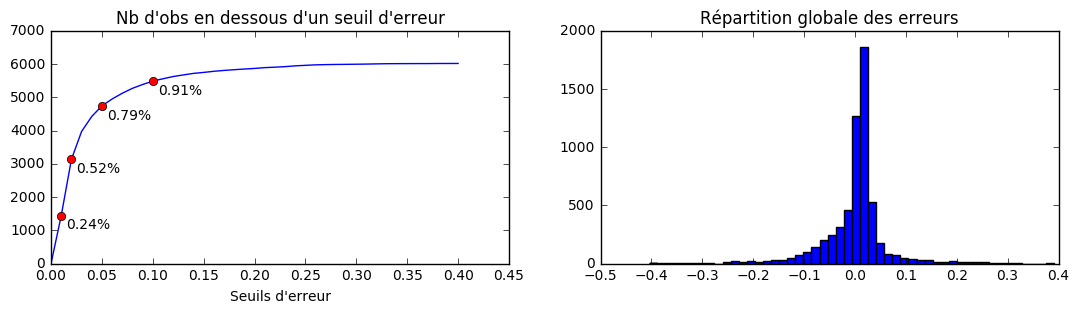

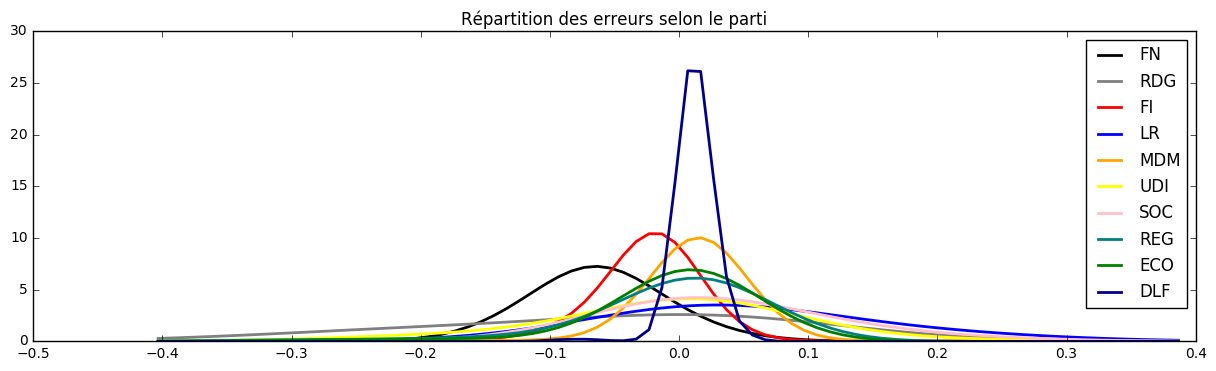

In [116]:
df_predictions = get_classif(y_pred_rf, y_val, df_id, target_values, strategy)
analyze_predictions(df_predictions, target_values)

In [591]:
df_predictions.sort_values(by='ecart').head(3)

,an,dep,circo,code,nom,prenom,nuance_groupe,taux_vote_leg,second_tour,p_exprimes,prediction,classement,qualif,ecart
13113,2012,SAINT-PIERRE-ET-MIQUELON,1,975|1,GIRARDIN,ANNICK,RDG,0.5186,E,0.6552,0.096528,4,N,-0.558672
10982,2012,LA-REUNION,2,974|2,BELLO,HUGUETTE,DVG,0.4562,E,0.6712,0.221551,2,O,-0.449649
12340,2012,PARIS,6,75|6,DUFLOT,CECILE,ECO,0.5929,O,0.4874,0.064594,4,N,-0.422806


In [592]:
df_predictions.sort_values(by='ecart').tail(3)

,an,dep,circo,code,nom,prenom,nuance_groupe,taux_vote_leg,second_tour,p_exprimes,prediction,classement,qualif,ecart
8653,2012,CALVADOS,5,14|5,NOUVELOT,CEDRIC,LR,0.5970,O,0.2402,0.555583,1,E,0.315383
9452,2012,FRANCAIS-DE-L'ETRANGER,2,99|2,DROUHAUD,PASCAL,LR,0.1573,O,0.2276,0.548723,1,E,0.321123
13116,2012,SAINT-PIERRE-ET-MIQUELON,1,975|1,ZIMMERMANN,FRANCOIS,LR,0.5186,N,0.1132,0.442358,1,O,0.329158


#### Save predictions

In [318]:
from datetime import datetime
now = datetime.now()
stamp = '{}_{}_{}h{}'.format(now.day, now.month, now.hour, now.minute)
df_predictions.to_excel('predictions_du_{}.xlsx'.format(stamp))

In [ ]:
#todo : utiliser nuance et pas nuance groupe
exportCsv = df_predictions[['code','prenom','nom','nuance_groupe','prediction','qualif']]
exportCsv['code'] = exportCsv['code'].apply(str.lower)
exportCsv['code'] = exportCsv['code'].apply(lambda x : x.replace('|', '-'))
exportCsv['candidat'] = exportCsv['prenom'] + ' ' + exportCsv['nom']


exportCsv1 = exportCsv[exportCsv['qualif'] == 'O']
vainqueurs1er = exportCsv[exportCsv['qualif'] == 'E']

exportCsv1 = exportCsv1.drop(['prenom','nom','qualif'], axis=1)
exportCsv1 = exportCsv1.sort_values(['code', 'prediction'], ascending=[True, False])

circos = exportCsv1['code'].unique()
temp = pd.DataFrame()
d = {}
for c in circos:
    temp = exportCsv1[exportCsv1['code'] == c]
    l = []
    for index, rows in temp.iterrows():
        l.extend(rows[1:].values)
    d[c] = l

duels = {k: v for k, v in d.items() if len(v) < 7}
triangulaires = {k: v for k, v in d.items() if len(v) > 6 and len(v) < 10}
quadrangulaires = {k: v for k, v in d.items() if len(v) > 10}

duels = pd.DataFrame(duels)
duels.index = ['color1','score1','candidat1','color2','score2','candidat2']
duels = duels.T
#duels['color3'],duels['score3'],duels['candidat3'],duels['color4'],duels['score4'],duels['candidat4'] = '','','','','',''
print(duels.head())

triangulaires = pd.DataFrame(triangulaires)
triangulaires.index = ['color1','score1','candidat1','color2','score2','candidat2','color3','score3','candidat3']
triangulaires = triangulaires.T
#triangulaires['color4'], triangulaires['score4'], triangulaires['candidat4'] = '','',''

print(triangulaires.head())

quadrangulaires = pd.DataFrame(quadrangulaires)
quadrangulaires.index = ['color1','score1','candidat1','color2','score2','candidat2','color3',
                         'score3','candidat3','color4','score4','candidat4']
quadrangulaires = quadrangulaires.T
print(quadrangulaires.head())

vainqueurs1er.index = vainqueurs1er.code
vainqueurs1er = vainqueurs1er.drop(['code','prenom','nom','qualif'], axis=1)
vainqueurs1er['color1'], vainqueurs1er['score1'], vainqueurs1er['candidat1'] = vainqueurs1er.nuance_groupe,\
vainqueurs1er.prediction, vainqueurs1er.candidat
vainqueurs1er = vainqueurs1er.drop(['nuance_groupe', 'prediction', 'candidat'], axis=1)
print(vainqueurs1er.head())


final = pd.concat([vainqueurs1er, duels, triangulaires, quadrangulaires])
final = final.fillna(value='')
final.index.name = 'circo'
final['nom circo'] = 'Davy Champion'
print(final.head())
final.to_csv('dataviz/data/resultats1.csv', index=True)